# Estratégia "Um Contra Todos" para Classificação de Dígitos

Para construir um classificador para os quatro dígitos contidos na base, utiliza-se a estratégia **"Um Contra Todos"** (*One-vs-All*).

## Passo a Passo

1. **Escolha de um dígito positivo**  
   Inicialmente, escolhe-se um dígito específico (por exemplo, **0**) para ser a classe **𝑦 = +1**.

2. **Agrupamento dos demais dígitos**  
   Todos os outros dígitos (por exemplo, **1, 4 e 5**) são temporariamente definidos como a classe **𝑦 = −1**.

3. **Treinamento do modelo**  
   O modelo é treinado para distinguir o dígito escolhido (**positivo**) de todos os outros (**negativos**).

4. **Repetição para cada dígito**  
   O processo é repetido para cada dígito que se deseja classificar. Assim, teremos um classificador separado para cada número.

## Exemplo de Transformação

Se o conjunto de rótulos originais for:



In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

In [132]:
class OneVsAllClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_clf):
        self.base_clf = base_clf
        self.classifiers = {}
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for cls in self.classes_[:-1]:  # até o penúltimo (último é o "resto")
            y_bin = np.where(y == cls, 1, -1)
            clf = self.base_clf()
            clf.fit(X, y_bin)
            self.classifiers[cls] = clf
        return self

    def predict(self, X):
        y_pred = np.full(X.shape[0], self.classes_[-1])  # default = última classe
        for cls in self.classes_[:-1]:
            pred_bin = self.classifiers[cls].predict(X)
            mask = (pred_bin == 1)
            y_pred[mask] = cls
        return y_pred


In [133]:
def classificar_uma_amostra(x, classificadores):
    for d in [0, 1, 4]:
        if classificadores[d].predict([x])[0] == 1:
            return d
    return 5  # nenhum positivo => dígito 5

In [134]:
def treinar_um_contra_todos(classificador, X_train, y_train, X_test, y_test):
    """
    Treina classificadores no esquema Um-Contra-Todos (One-vs-All)
    para os dígitos 0, 1 e 4. Retorna os classificadores e previsões.
    """
    digitos_alvo = [0, 1, 4]
    classificadores = {}

    for idx, digito in enumerate(digitos_alvo):
        y_bin = np.where(y_train == digito, 1, -1)
        if idx > 0:
            mask = y_train != digitos_alvo[idx - 1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        clf = classificador()
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    # Predição
    previsoes = []
    for x in X_test:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            if clf.predict(x_scaled)[0] == 1:
                pred = digito
                break
        if pred is None:
            pred = 5
        previsoes.append(pred)

    print(f"\nModelo: {classificador.__name__}")
    print(classification_report(y_test, previsoes, digits=2))

    return classificadores, previsoes


In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import numpy as np

def treinar_um_contra_todos_linear(X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4]):
    """
    Treina classificadores lineares (LinearRegression) no esquema 'Um Contra Todos' (One-vs-All)
    para os dígitos indicados em digitos_alvo. O dígito 5 será atribuído quando nenhum classificador
    responder positivo.

    Parâmetros:
        X_train, y_train : dados de treino
        X_test, y_test   : dados de teste
        digitos_alvo     : lista dos dígitos que terão classificadores binários

    Retorna:
        classificadores : dict {digito: (modelo, scaler)}
        previsoes       : lista de previsões para X_test
    """
    classificadores = {}

    # Treinamento de cada classificador binário
    for idx, digito in enumerate(digitos_alvo):
        # Rótulos binários: +1 para digito alvo, -1 para os demais
        y_bin = np.where(y_train == digito, 1, -1)

        if idx > 0:
            # Remover amostras do dígito anterior
            mask = y_train != digitos_alvo[idx-1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        # Escalonamento
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        # Treinamento do LinearRegression
        clf = LinearRegression()
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    # Predição no conjunto de teste
    previsoes = []
    for x in X_test:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            y_cont = clf.predict(x_scaled)[0]
            if y_cont >= 0:  # limiar zero para decidir +1 / -1
                pred = digito
                break
        if pred is None:
            pred = 5  # nenhum classificador respondeu positivo
        previsoes.append(pred)

    print("=== Relatório de classificação Linear ===")
    print(classification_report(y_test, previsoes, digits=2))

    return classificadores, previsoes


In [136]:
def plot_decision_boundary(clf, X, y, titulo):
    # Cria malha de pontos para o plano
    h = 0.02  # passo
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predição para cada ponto da malha
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot do contorno e dos pontos
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.tab10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title(titulo)

In [137]:
def plot_um_contra_todos(classificadores, X, y, digitos_alvo=[0,1,4]):
    """
    Plota os pontos de treino e as linhas de fronteira dos classificadores
    treinados em esquema 'um contra todos'.

    classificadores: dict {digito: (modelo, scaler)}
    X, y: dados de treino (para plotar os pontos)
    digitos_alvo: lista dos dígitos com classificadores treinados
    """
    # Cores para os pontos
    cores_pontos = {0:'red', 1:'blue', 4:'green', 5:'orange'}

    plt.figure(figsize=(10,8))

    # Plotar os pontos
    for digito in np.unique(y):
        mask = y == digito
        plt.scatter(X[mask, 0], X[mask, 1],
                    c=cores_pontos[digito], edgecolors='k', alpha=0.6,
                    label=f'Dígito {digito}')

    # Criar grid para as fronteiras
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Plotar a fronteira de cada classificador binário
    cores_linhas = {0:'red', 1:'blue', 4:'green'}
    for digito, (modelo, scaler) in classificadores.items():
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_scaled = scaler.transform(grid_points)
        Z = modelo.predict(grid_scaled)
        Z = Z.reshape(xx.shape)
        # Apenas a linha da fronteira (onde Z muda de -1 para 1)
        plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
                    linestyles='--', linewidths=2,
                    label=f'Fronteira {digito} vs todos')

    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title("Fronteiras de decisão - Um Contra Todos")
    plt.legend()
    plt.show()

In [138]:
def plot_um_contra_todos_linear(classificadores, X, y, digitos_alvo=[0,1,4]):
    """
    Plota os pontos de treino, áreas de decisão e linhas de fronteira
    dos classificadores Lineares treinados com o esquema 'Um Contra Todos'.
    
    classificadores: dict {digito: (modelo, scaler)}
    X, y: dados de treino
    digitos_alvo: lista dos dígitos com classificadores treinados
    """
    # Cores para cada classe
    cores_pontos = {0:'red', 1:'blue', 4:'green', 5:'orange'}
    cores_linha = {0:'red', 1:'blue', 4:'green'}

    plt.figure(figsize=(10,8))

    # Pontos de treino
    for digito in np.unique(y):
        mask = y == digito
        plt.scatter(X[mask,0], X[mask,1], 
                    c=cores_pontos[digito], edgecolors='k', alpha=0.6,
                    label=f'Dígito {digito}')

    # Criar grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Inicializa como dígito 5
    Z = np.full(grid_points.shape[0], 5)
    for digito, (modelo, scaler) in classificadores.items():
        grid_scaled = scaler.transform(grid_points)
        y_cont = modelo.predict(grid_scaled)
        mask = y_cont >= 0
        Z[mask] = digito

    Z = Z.reshape(xx.shape)

    # Plotar linhas de fronteira de cada classificador
    for digito, (modelo, scaler) in classificadores.items():
        grid_scaled = scaler.transform(grid_points)
        y_cont = modelo.predict(grid_scaled).reshape(xx.shape)
        plt.contour(xx, yy, y_cont, levels=[0], colors=cores_linha[digito],
                    linestyles='--', linewidths=2)

    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title("Fronteiras de decisão - Regressão Linear (Um Contra Todos)")
    plt.legend()
    plt.show()


In [139]:
train = pd.read_csv('dataset/train_redu.csv')
test = pd.read_csv('dataset/test_redu.csv')

In [140]:
# Junta treino e teste caso queira embaralhar e dividir novamente
df = pd.concat([train, test], ignore_index=True)

# Filtra apenas dígitos 0, 1, 4 e 5
df = df[df['label'].isin([0, 1, 4, 5])]

# Separa features (X) e rótulos (y)
X = df.drop(columns=['label']).values
y = df['label'].values

# Divide em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       193
           1       1.00      1.00      1.00       270
           4       0.90      0.93      0.91       268
           5       0.92      0.89      0.90       260

    accuracy                           0.95       991
   macro avg       0.95      0.95      0.95       991
weighted avg       0.95      0.95      0.95       991



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19700\3078699305.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19700\3078699305.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19700\3078699305.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],


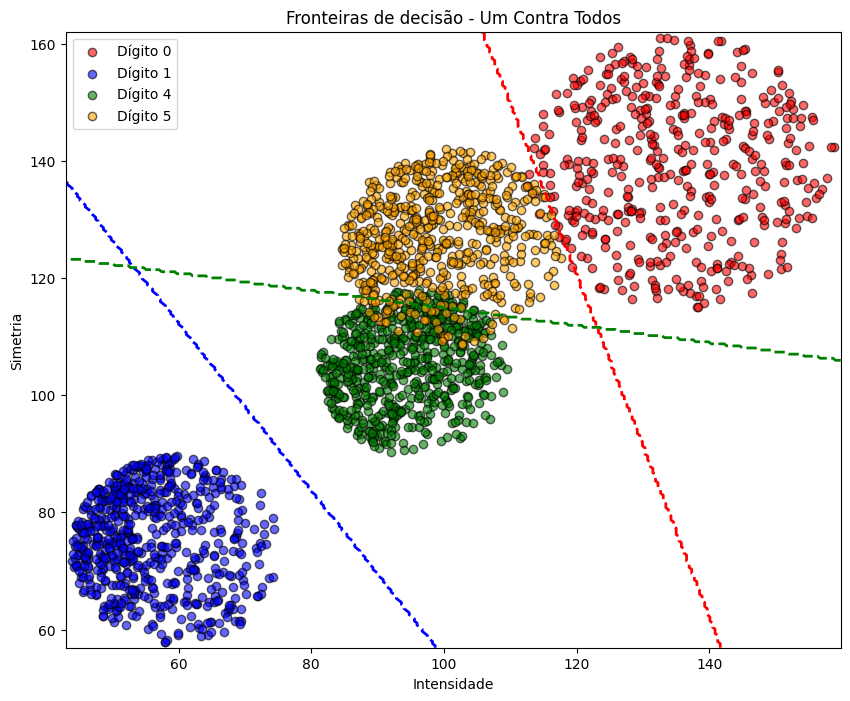

In [141]:
# Treinar os classificadores usando LogisticRegression como exemplo
classificadores, previsoes = treinar_um_contra_todos(LogisticRegression, X_train, y_train, X_test, y_test)

# Plotar as fronteiras usando a função que você tem
plot_um_contra_todos(classificadores, X_train, y_train)





Modelo: Perceptron
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       193
           1       1.00      1.00      1.00       270
           4       1.00      0.65      0.79       268
           5       0.73      0.97      0.83       260

    accuracy                           0.90       991
   macro avg       0.92      0.90      0.90       991
weighted avg       0.92      0.90      0.89       991



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19700\3078699305.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19700\3078699305.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19700\3078699305.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],


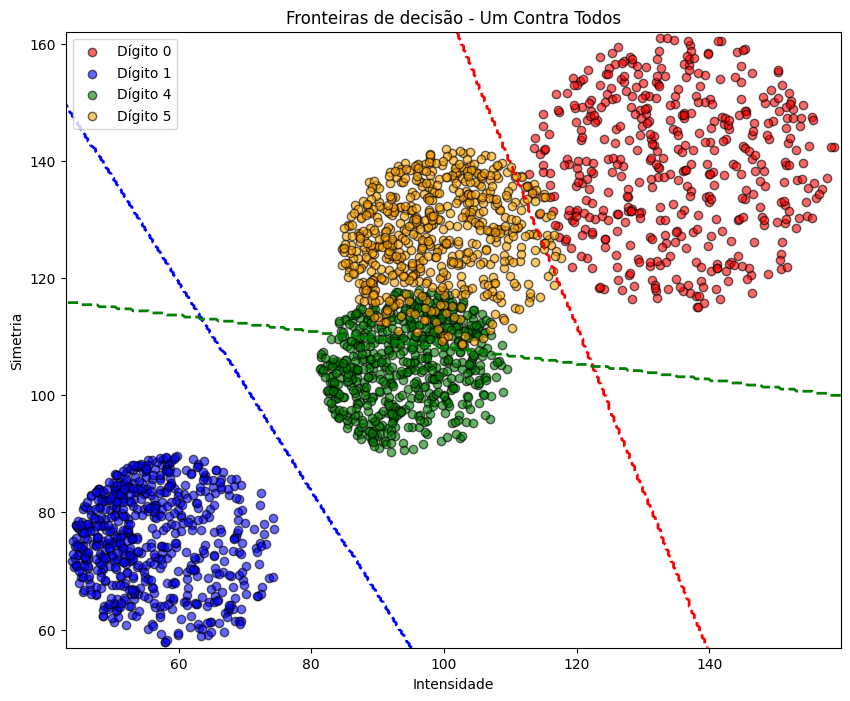

In [142]:
# Treinar os classificadores usando LogisticRegression como exemplo
classificadores, previsoes = treinar_um_contra_todos(Perceptron, X_train, y_train, X_test, y_test)

# Plotar as fronteiras usando a função que você tem
plot_um_contra_todos(classificadores, X_train, y_train)

=== Relatório de classificação Linear ===
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       193
           1       1.00      1.00      1.00       270
           4       0.88      0.97      0.92       268
           5       0.82      0.86      0.84       260

    accuracy                           0.91       991
   macro avg       0.92      0.90      0.91       991
weighted avg       0.92      0.91      0.91       991



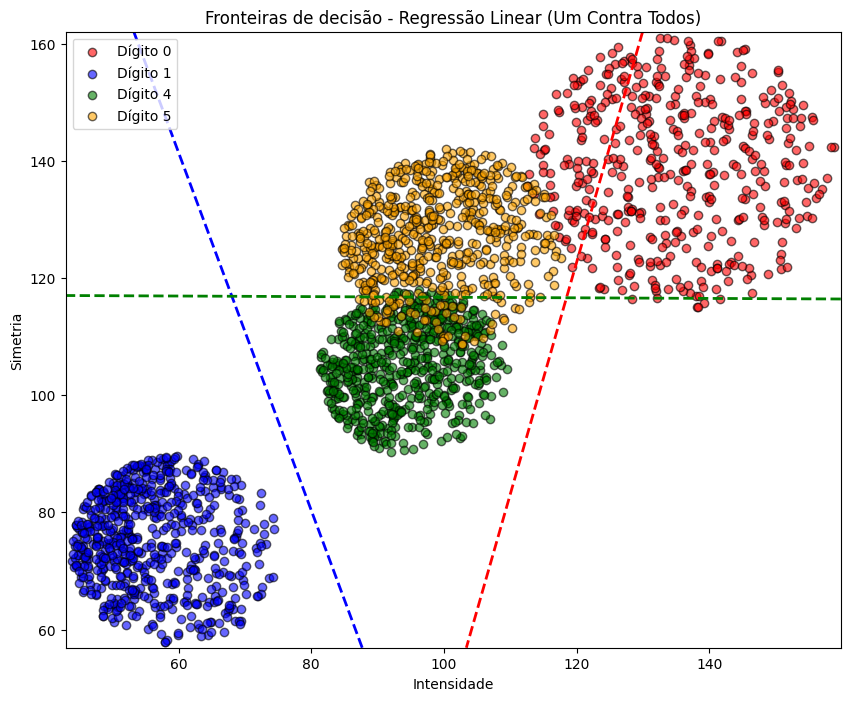

In [143]:
# Supondo que você já treinou:
classificadores_lr, preds_lr = treinar_um_contra_todos_linear(X_train, y_train, X_test, y_test)

# Plotar as fronteiras
plot_um_contra_todos_linear(classificadores_lr, X_train, y_train)
